In [9]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from collections import defaultdict
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from bgspy.theory import bgs_rec, bgs_segment_sc16, bgs_segment
from bgspy.parallel import MapPosChunkIterator
from bgspy.classic import calc_B_SC16_chunk_worker
from bgspy.genome import Genome


In [11]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [27]:
bgs_segment_sc16(1e-8, 1e-5, 1000, 1e-4, 1000, full_output=True)

(array([101006.69930408,    999.9991813 ]),
 array({'nfev': 5, 'fjac': array([[-9.99999974e-01, -2.29243588e-04],
        [ 2.29243588e-04, -9.99999974e-01]]), 'r': array([ 9.90033240e-06, -9.80409052e-06,  1.00000268e-03]), 'qtf': array([ 6.92011542e-14, -3.34859137e-13]), 'fvec': array([1.77635684e-15, 8.88178420e-16])},
       dtype=object),
 array(1),
 array('The solution converged.', dtype='<U23'))

In [13]:
sh = np.logspace(-5, -1, 50)

In [14]:
mu = np.logspace(-9, -7, 3)[:, None, None]
sh = np.logspace(-5, -1, 4)[None, :, None]

sc16 = bgs_segment_sc16(mu, sh, [1000, 1000, 1000], [1e-8, 1e-8, 1e-8], 1000)

/home/vsb/projects/bprime/bgspy/theory.py:56: UserWarning: no solution found!
  return np.nan


In [51]:
sc16.shape

(3, 4, 3)

In [ ]:
mu = np.logspace(-9, -7, 3)[:, None, None]
sh = np.logspace(-5, -1, 4)[None, :, None]

n = 100
L = np.random.randint(1, 100, n)
rbp = np.random.uniform(1e-9, 1e-7, n)



def manual_vectorization(mu, sh, L, rbp):
    B = defaultdict(list)
    for i in range(len(L)):
        for s in np.nditer(sh):
            for m in np.nditer(mu):
                b = bgs_segment_sc16(m, s, L[i], rbp[i], 1000)
                B[(float(m), float(s))].append(float(b))
    for key, val in B.items():
        B[key] = np.prod(np.array(val))
    return B
            

np.prod(bgs_segment_sc16(mu, sh, L, rbp, 1000), axis=2)

In [83]:
manual_vectorization(mu, sh, L, rbp)

defaultdict(list,
            {(1e-09, 1e-05): 0.9999995275214734,
             (1e-08, 1e-05): 0.9999952752257816,
             (1e-07, 1e-05): 0.9999527533439342,
             (1e-09, 0.00021544346900318823): 0.9998227361967416,
             (1e-08, 0.00021544346900318823): 0.9982288812972477,
             (1e-07, 0.00021544346900318823): 0.9824397265782665,
             (1e-09, 0.004641588833612777): 0.9989737276427394,
             (1e-08, 0.004641588833612777): 0.9897845698902533,
             (1e-07, 0.004641588833612777): 0.902418518629823,
             (1e-09, 0.1): 0.999952201911636,
             (1e-08, 0.1): 0.9995221219125683,
             (1e-07, 0.1): 0.9952314825838448})

In [123]:
mu

array([[[1.e-09]],

       [[1.e-08]],

       [[1.e-07]]])

In [124]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments(split_length=10_000)
g
chunks = MapPosChunkIterator(g,  mu.squeeze(), sh.squeeze(), 1000, 5000)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


In [125]:
chunk = next(chunks)

In [126]:
map_positions, chrom_seg_mpos, seg_L, _, w_grid, t_grid = chunk

In [127]:
map_positions.shape

(27,)

In [146]:
res = calc_B_SC16_chunk_worker(chunk)

/home/vsb/projects/bprime/bgspy/theory.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(val)


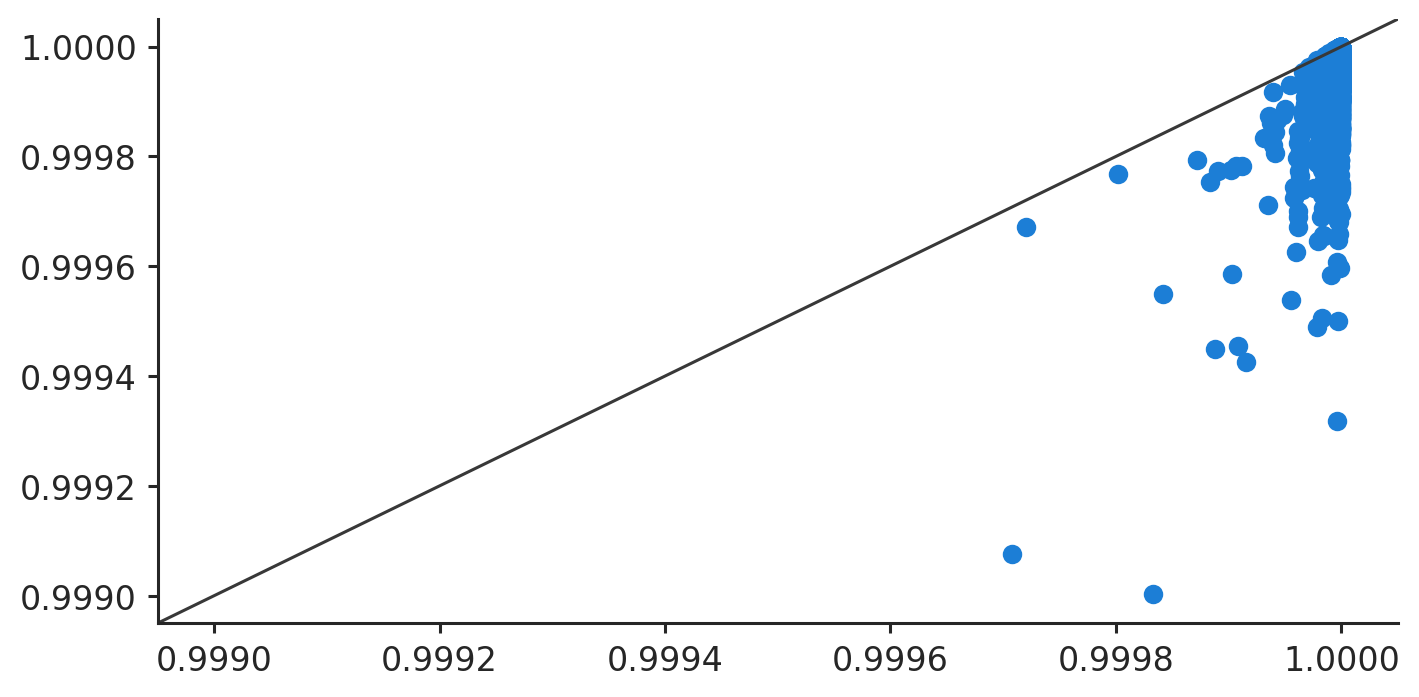

In [147]:
plt.scatter(res[0][1, 3, :], res[1][1, 3, :])
plt.axline((0.999, 0.999), slope=1, c='0.22')

In [ ]:
np.exp(res[0])

In [113]:
res_old = calc_B_SC16_chunk_worker(chunk, False)

/home/vsb/projects/bprime/bgspy/theory.py:16: RuntimeWarning: overflow encountered in exp
  return np.exp(val)


In [120]:
np.exp(res_old[0])[1, 3, :], np.exp(res[0])[1, 3, :]

IndexError: index 3 is out of bounds for axis 1 with size 1

In [122]:
np.exp(res_old[0]).shape, np.exp(res[0]).shape

((3, 1, 4, 6239), (3, 1, 4, 6239))

In [52]:
mu.squeeze(), sh.squeeze()

(array([1.e-09, 1.e-08, 1.e-07]),
 array([1.00000000e-05, 2.15443469e-04, 4.64158883e-03, 1.00000000e-01]))

In [53]:
sc16[1, :, 0]

array([0.99999901, 0.99963073, 0.99785585, 0.99990001])

In [54]:
bgs_segment_sc16(1e-8, sh, 1000, 1e-8, 1000)

array([[[0.99999901],
        [0.99963073],
        [0.99785585],
        [0.99990001]]])

In [38]:
bgs_segment_sc16(mu, sh[0], L, rf, N)

array(nan)

In [40]:
mu, sh[0], L, rf, N

(1e-08, 1e-05, 1000, 1e-08, 1000)

In [53]:
bgs_segment_sc16(1e-8, 1e-4, 10, 1e-8, 1000)

array(0.9999991)

(0.99, 1.002)

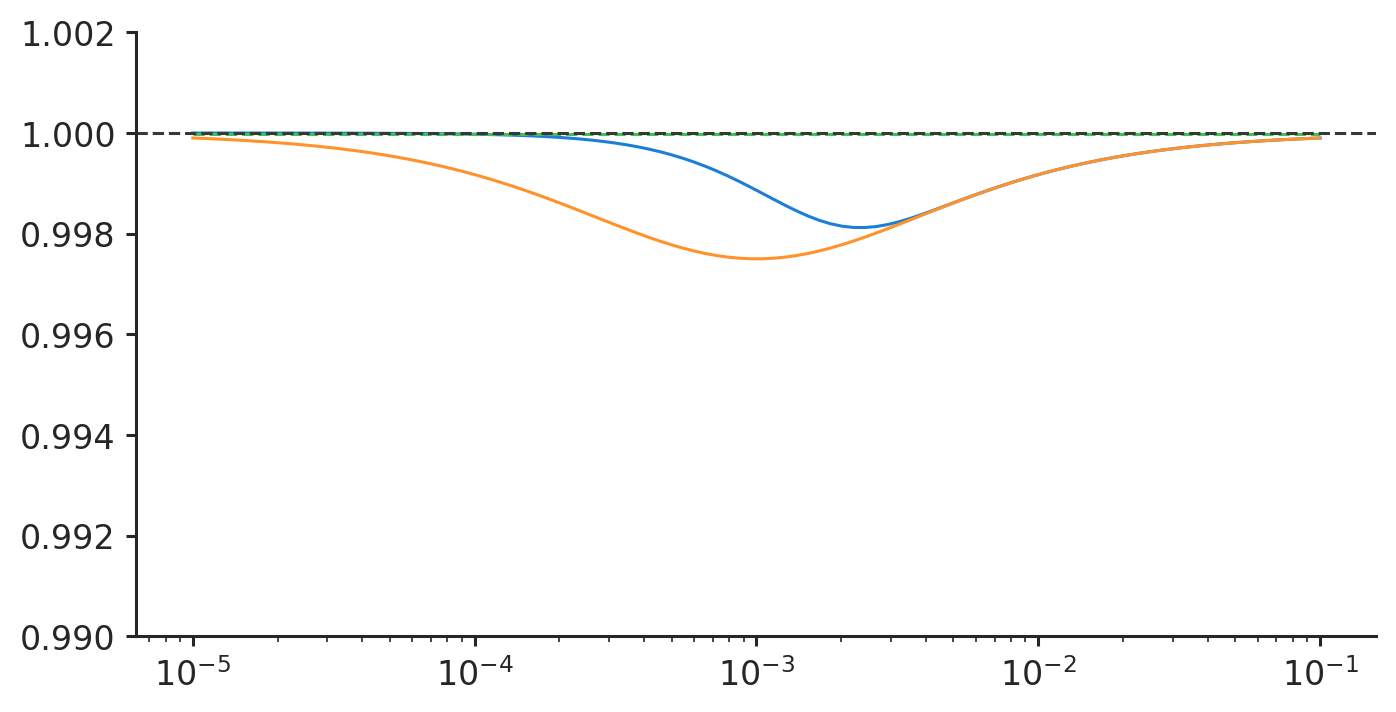

In [56]:
mu = 1e-8
rf = 0.001
#rf = 1e-8
sh = np.logspace(-5, -1, 100)
L = 1000
N = 1000
sc16 = bgs_segment_sc16(mu, sh, L, rf, N)

plt.plot(sh, sc16)
plt.plot(sh, bgs_rec(mu, sh, L, rf))
plt.plot(sh, bgs_segment(mu, sh, L, rf, 1e-8), linestyle='dashed')
plt.semilogx()
plt.axhline(1, linestyle='dashed', c='0.22')
#plt.ylim(np.nanmin(sc16)*0.999, 1.0002)
plt.ylim(0.99, 1.002)

[]

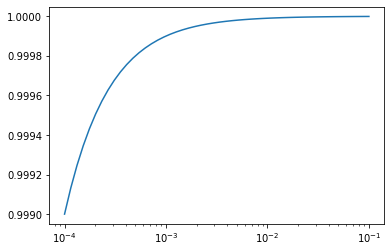

In [81]:
plt.plot(sh, bgs_rec(1e-8, sh, 10, 1e-8))
plt.semilogx()